In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from astropy.table import Table
from astropy.io import fits
from sky import fit_gauss, gauss
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torchvision import datasets, transforms
import torchvision.datasets as dset
from kymatio.torch import Scattering2D
import tqdm
import shutil
from matplotlib.colors import ListedColormap, TABLEAU_COLORS
import os
import pickle



In [4]:

def load_pkl_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

# Example usage

best_l2_indices = load_pkl_file("best_l2_indices.pkl")
best_sc_l2_inds = load_pkl_file("best_sc_l2_inds.pkl")
best_sc_l1_inds = load_pkl_file("best_sc_l1_inds.pkl")
tng_ims = load_pkl_file("tng_ims.pkl")
sdss_ims = load_pkl_file("sdss_ims.pkl")
#sdss_loader = load_pkl_file("sdss_loader.pkl")
tng_loader = load_pkl_file("tng_loader.pkl")
print(best_l2_indices)

[array([10491, 13870, 11918, 10489,  6328]), array([4233, 2054, 9824, 3910, 6305]), array([ 1247,   398,  9981, 10489,  1133]), array([ 4665,  2314, 10166,  7598,  8470]), array([ 7640,  8083,  4191, 10644, 12840]), array([  399,  3980, 12149,  6420, 10535]), array([5801, 3548, 9329,  178, 6204]), array([2124, 3559,  759,  129, 6177]), array([ 4561,  1957, 13156, 10282,  4313]), array([7262, 2331, 7512, 2126, 8617]), array([ 3559,  9322, 12000,  6356,  2264]), array([   17,  8184, 13331,    81, 11290]), array([12333,  5020, 13947, 11887,   235]), array([ 8546,  7010, 13662,  6509,  5149]), array([11712,  4421, 12649,    28,  4636]), array([ 8562, 13003,  8260, 11719,  3457]), array([ 2438,  6087,  4899,  3412, 12295]), array([ 9692,  3978, 12375,  3318,  7862]), array([ 7130,  6427,  5616,  2603, 13479]), array([ 5372,   624, 11294,  8395, 12715]), array([  898,  8315,  9230, 12426,  1306]), array([5476, 6893, 4223,  412, 2917]), array([6893,  385, 9071, 2770, 8382]), array([ 4961, 138

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(),normalize])

In [6]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class CustomImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('jpg', 'png', 'jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Assuming 'transform' is defined elsewhere in your code
sdss_set = CustomImageDataset('dataset/sdss', transform=transform)
sdss_loader = DataLoader(sdss_set, shuffle=False, pin_memory=True)

In [5]:
len(sdss_ims)

16981

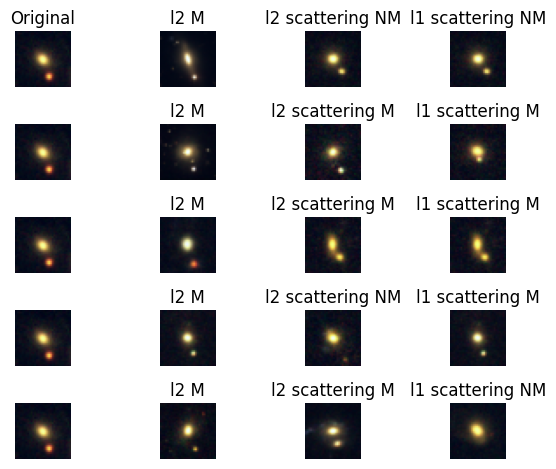

In [7]:
import matplotlib.pyplot as plt

ind = 1478
fix,axes = plt.subplots(5,4)
axes[0,0].set_title("Original")
axes[0,1].set_title("l2")
axes[0,2].set_title("l2 on scattering")
axes[0,3].set_title("l1 on scattering")
orig = sdss_ims[ind].squeeze().numpy().transpose(1,2,0)
orig = orig - orig.min()
orig = orig / orig.max()

l2_arr=[]
l2_arr_imgs=[]
l2_arr_labels=[]
l2_on_scattering_arr=[]
l2_on_scatter_imgs=[]
l2_on_scatter_labels=[]
l1_on_scattering_arr=[]
l1_on_scatter_imgs=[]
l1_on_scatter_labels=[]
for i in range (5):
    axes[i,0].imshow(orig); axes[i,0].axis('off')

    l2im = tng_ims[best_l2_indices[ind][i]].squeeze().numpy().transpose(1,2,0)
    l2im = l2im - l2im.min()
    l2im = l2im / l2im.max()
    label_l2=""
    label_l2_scatter=""
    label_l1_scatter=""
    l2_arr.append(tng_loader.dataset.samples[best_l2_indices[ind][i]][0].split('/')[-1][:-6])
    if '/merger' in tng_loader.dataset.samples[best_l2_indices[ind][i]][0]:
        label_l2 = 'M'
    else:
        label_l2 = 'NM'
    l2_arr_labels.append(label_l2)
    axes[i,1].imshow(l2im); axes[i,1].axis('off'); axes[i,1].set_title(f"l2 {label_l2}")
    l2_arr_imgs.append(l2im)
    
    scim2 = tng_ims[best_sc_l2_inds[ind][i]].squeeze().numpy().transpose(1,2,0)
    scim2 = scim2 - scim2.min()
    scim2 = scim2 / scim2.max()
    l2_on_scattering_arr.append(tng_loader.dataset.samples[best_sc_l2_inds[ind][i]][0].split('/')[-1][:-6])
    if '/merger' in tng_loader.dataset.samples[best_sc_l2_inds[ind][i]][0]:
        label_l2_scatter = 'M'
    else:
        label_l2_scatter = 'NM'
    l2_on_scatter_labels.append(label_l2_scatter)
    axes[i,2].imshow(scim2); axes[i,2].axis('off'); axes[i,2].set_title(f"l2 scattering {label_l2_scatter}")
    l2_on_scatter_imgs.append(scim2)
    
    scim1 = tng_ims[best_sc_l1_inds[ind][i]].squeeze().numpy().transpose(1,2,0)
    scim1 = scim1 - scim1.min()
    scim1 = scim1 / scim1.max()
    l1_on_scattering_arr.append(tng_loader.dataset.samples[best_sc_l1_inds[ind][i]][0].split('/')[-1][:-6])
    if '/merger' in tng_loader.dataset.samples[best_sc_l1_inds[ind][i]][0]:
        label_l1_scatter = 'M'
    else:
        label_l1_scatter = 'NM'
    l1_on_scatter_labels.append(label_l1_scatter)
    axes[i,3].imshow(scim1); axes[i,3].axis('off'); axes[i,3].set_title(f"l1 scattering {label_l1_scatter}")
    l1_on_scatter_imgs.append(scim1)
    
plt.tight_layout()

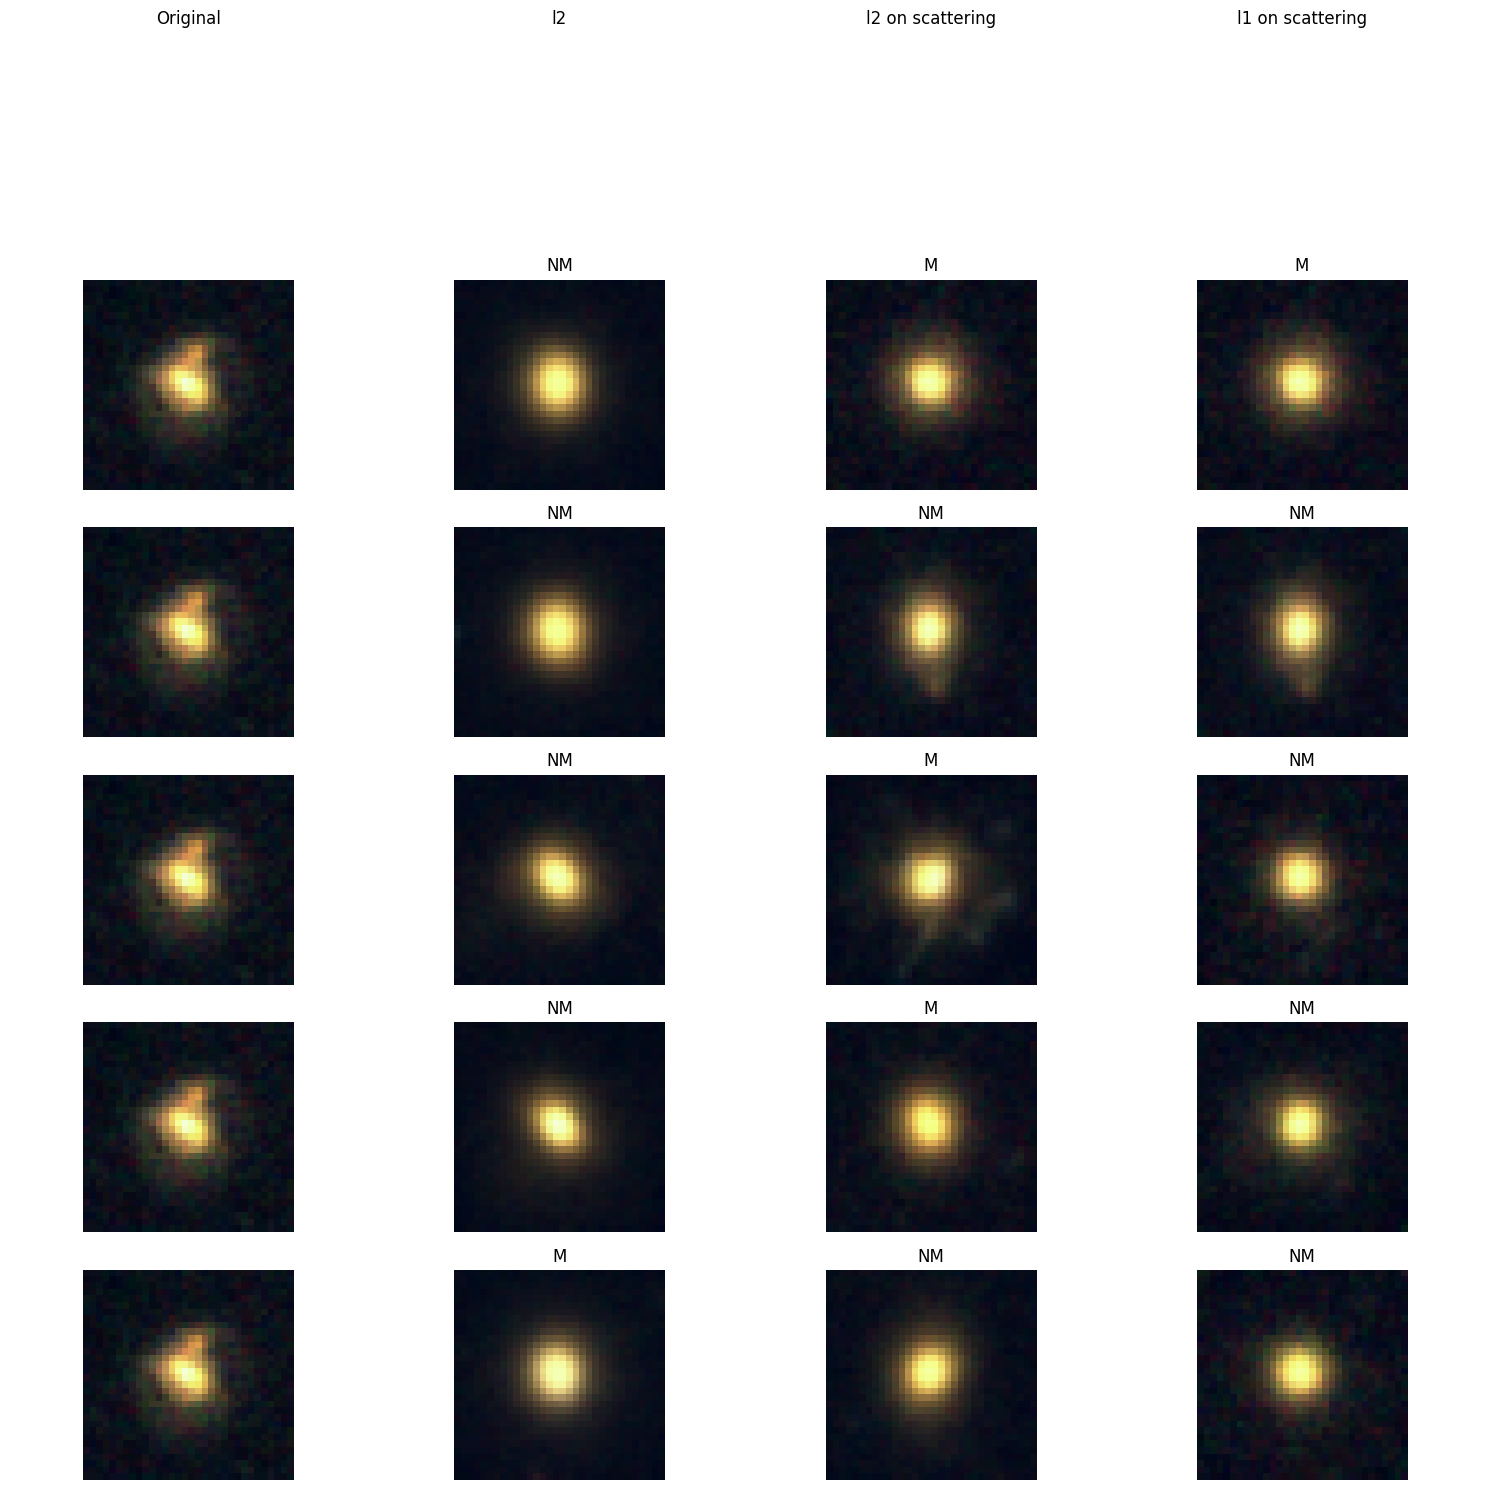

In [9]:
import matplotlib.pyplot as plt

ind = 0
fix, axes = plt.subplots(6, 4, figsize=(15, 15))  # Create an extra row for titles

# Set titles for the columns
axes[0, 0].set_title("Original")
axes[0, 1].set_title("l2")
axes[0, 2].set_title("l2 on scattering")
axes[0, 3].set_title("l1 on scattering")

# Hide the first row of axes (used for titles)
for ax in axes[0]:
    ax.axis('off')

orig = sdss_ims[ind].squeeze().numpy().transpose(1, 2, 0)
orig = orig - orig.min()
orig = orig / orig.max()

orig_path=sdss_loader.dataset.image_paths[ind].split("/")[-1][:-4]
l2_arr = []
l2_arr_imgs = []
l2_arr_labels = []
l2_on_scattering_arr = []
l2_on_scatter_imgs = []
l2_on_scatter_labels = []
l1_on_scattering_arr = []
l1_on_scatter_imgs = []
l1_on_scatter_labels = []
for i in range(5):
    axes[i + 1, 0].imshow(orig)
    axes[i + 1, 0].axis('off')

    l2im = tng_ims[best_l2_indices[ind][i]].squeeze().numpy().transpose(1, 2, 0)
    l2im = l2im - l2im.min()
    l2im = l2im / l2im.max()
    label_l2 = ""
    label_l2_scatter = ""
    label_l1_scatter = ""
    l2_arr.append(tng_loader.dataset.samples[best_l2_indices[ind][i]][0].split('/')[-1][:-6])
    if '/merger' in tng_loader.dataset.samples[best_l2_indices[ind][i]][0]:
        label_l2 = 'M'
    else:
        label_l2 = 'NM'
    l2_arr_labels.append(label_l2)
    axes[i + 1, 1].imshow(l2im)
    axes[i + 1, 1].axis('off')
    axes[i + 1, 1].set_title(label_l2)
    l2_arr_imgs.append(l2im)

    scim2 = tng_ims[best_sc_l2_inds[ind][i]].squeeze().numpy().transpose(1, 2, 0)
    scim2 = scim2 - scim2.min()
    scim2 = scim2 / scim2.max()
    l2_on_scattering_arr.append(tng_loader.dataset.samples[best_sc_l2_inds[ind][i]][0].split('/')[-1][:-6])
    if '/merger' in tng_loader.dataset.samples[best_sc_l2_inds[ind][i]][0]:
        label_l2_scatter = 'M'
    else:
        label_l2_scatter = 'NM'
    l2_on_scatter_labels.append(label_l2_scatter)
    axes[i + 1, 2].imshow(scim2)
    axes[i + 1, 2].axis('off')
    axes[i + 1, 2].set_title(label_l2_scatter)
    l2_on_scatter_imgs.append(scim2)

    scim1 = tng_ims[best_sc_l1_inds[ind][i]].squeeze().numpy().transpose(1, 2, 0)
    scim1 = scim1 - scim1.min()
    scim1 = scim1 / scim1.max()
    l1_on_scattering_arr.append(tng_loader.dataset.samples[best_sc_l1_inds[ind][i]][0].split('/')[-1][:-6])
    if '/merger' in tng_loader.dataset.samples[best_sc_l1_inds[ind][i]][0]:
        label_l1_scatter = 'M'
    else:
        label_l1_scatter = 'NM'
    l1_on_scatter_labels.append(label_l1_scatter)
    axes[i + 1, 3].imshow(scim1)
    axes[i + 1, 3].axis('off')
    axes[i + 1, 3].set_title(label_l1_scatter)
    l1_on_scatter_imgs.append(scim1)

plt.tight_layout()
plt.show()

In [10]:
sdss_prefix = 'sdss/'
hdr0=fits.getheader('%s%s.fits' %(sdss_prefix, orig_path))
len(hdr0)

320

In [12]:
import sqlite3
import numpy as np
sdss_prefix = 'sdss/'
tng_prefix = 'tng/'
hdr0=fits.getheader('%s%s.fits' %(sdss_prefix, orig_path))
#orig_blob=orig.tobytes()
conn = sqlite3.connect('scattering_galaxy_data.db')
cursor = conn.cursor()

columns=['Scattering_INDEX INTEGER PRIMARY KEY', 'Image_ID TEXT', 'Image BLOB']
for key, value in hdr0.items():
    if key=='Unnamed: 0':
        continue
    if isinstance(value, str):
        columns.append(f"{key} TEXT")
    elif isinstance(value, int):
        columns.append(f"{key} INTEGER")
    elif isinstance(value, float):
        columns.append(f"{key} REAL")
    elif isinstance(value, bool):
        columns.append(f"{key} BOOLEAN")
    else:
        raise ValueError(f"Unsupported data type for column {key}")
    
print(len(columns))
    
create_table_query = f"CREATE TABLE IF NOT EXISTS sdss_data ({', '.join(columns)})"
cursor.execute(create_table_query)
conn.commit()
conn.close()

322


In [13]:
import sqlite3
import base64
import numpy as np
from astropy.io import fits

conn = sqlite3.connect('scattering_galaxy_data.db')
cursor = conn.cursor()
all_columns = ['Scattering_INDEX', 'Image_ID', 'Image'] + list(hdr0.keys())
all_columns.remove('Unnamed: 0')
print("Number of columns",len(all_columns))
placeholders = ', '.join(['?'] * len(all_columns))

for ind in range(len(sdss_ims)):
    orig = sdss_ims[ind].squeeze().numpy().transpose(1, 2, 0)
    orig = orig - orig.min()
    orig = orig / orig.max()
    # orig_blob=orig.tobytes()
    orig_base64 = base64.b64encode(orig.tobytes()).decode('utf-8')
    orig_path=sdss_loader.dataset.image_paths[ind].split("/")[-1][:-4]
    hdr=fits.getheader('%s%s.fits' %(sdss_prefix, orig_path))
    # if len(hdr)!=320:
    #     continue
    insert_query = f"INSERT INTO sdss_data ({', '.join(all_columns)}) VALUES ({placeholders})"
    #placeholders = ', '.join(['?'] * 322)
    #keys=[ k for k in hdr.keys() if k!='Unnamed: 0']

    values = [ind, orig_path, orig_base64] + [hdr.get(col, None) for col in all_columns[3:]]
    cursor.execute(insert_query, values)
    print((ind/len(sdss_ims))*100, '%')
conn.commit()
conn.close()

Number of columns 322
0.0 %
0.0058889346917142685 %
0.011777869383428537 %
0.017666804075142806 %
0.023555738766857074 %
0.029444673458571345 %
0.03533360815028561 %
0.04122254284199988 %
0.04711147753371415 %
0.05300041222542842 %
0.05888934691714269 %
0.06477828160885696 %
0.07066721630057123 %
0.0765561509922855 %
0.08244508568399976 %
0.08833402037571403 %
0.0942229550674283 %
0.10011188975914258 %
0.10600082445085685 %
0.11188975914257111 %
0.11777869383428538 %
0.12366762852599965 %
0.12955656321771392 %
0.1354454979094282 %
0.14133443260114245 %
0.1472233672928567 %
0.153112301984571 %
0.15900123667628524 %
0.16489017136799952 %
0.1707791060597138 %
0.17666804075142806 %
0.18255697544314234 %
0.1884459101348566 %
0.19433484482657087 %
0.20022377951828516 %
0.20611271420999938 %
0.2120016489017137 %
0.21789058359342794 %
0.22377951828514223 %
0.22966845297685648 %
0.23555738766857076 %
0.24144632236028502 %
0.2473352570519993 %
0.2532241917437136 %
0.25911312643542783 %
0.2650020

In [16]:
import sqlite3

# Connect to the database
conn = sqlite3.connect('scattering_galaxy_data.db')
cursor = conn.cursor()

# Define the row ID you want to display
#row_id = 1

# Execute the SELECT statement
# cursor.execute(f"SELECT * FROM sdss_data")
# row = cursor.fetchone()

# # Display the row
# print(row)

# Close the database connection
# Execute the SELECT statement
# cursor.execute(f"SELECT * FROM sdss_data")
# rows = cursor.fetchall()

query = f"PRAGMA table_info(sdss_data)"
cursor.execute(query)

# Get the column names
# columns = [description[0] for description in cursor.description]

# Print the column names
#print(columns)

# Print the row with column names
# for row in rows:
#     for i, value in enumerate(row):
#         print(f"{columns[i]}: {value}")
columns = cursor.fetchall()
column_count = len(columns)
print("Number of Columns: ",column_count)
# Close the database connection
conn.close()

Number of Columns:  322


In [14]:
sdss_prefix = 'sdss/'
hdr0=fits.getheader('%s%s.fits' %(sdss_prefix, orig_path))

In [15]:
for i,j in enumerate(hdr0.keys()):
    if j=='t08_odd_feature_a21_disturbed_fraction':
        print(i,j)

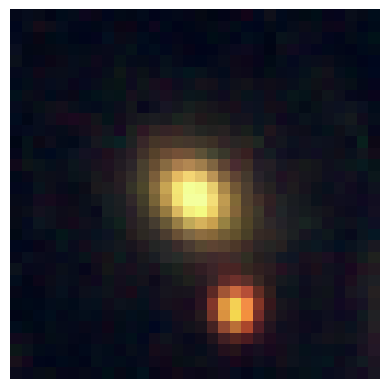

In [17]:
conn = sqlite3.connect('scattering_galaxy_data.db')
cursor = conn.cursor()

# Query to get the image data for Scattering_INDEX = 1478
query = "SELECT Image FROM sdss_data WHERE Scattering_INDEX = ?"
cursor.execute(query, (1478,))

# Fetch the image data
result = cursor.fetchone()
if result:
    image_base64 = result[0]
    # Decode the base64 string to bytes
    image_bytes = base64.b64decode(image_base64)
    # Convert bytes to numpy array
    image_array = np.frombuffer(image_bytes, dtype=np.float32)
    # Reshape the array to the original image shape (assuming the shape is known)
    image_array = image_array.reshape((32, 32, 3))  # Replace with actual dimensions

    # Display the image using matplotlib
    plt.imshow(image_array)
    plt.axis('off')  # Hide the axis
    plt.show()
else:
    print("No image found with Scattering_INDEX = 1478")

# Close the database connection
conn.close()

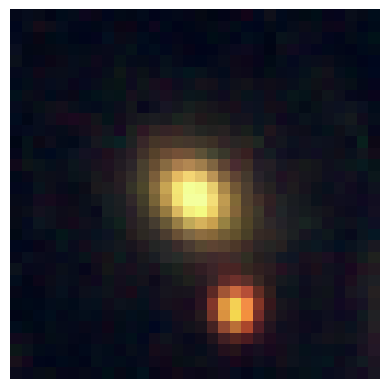

In [74]:
image_array = np.frombuffer(rows[1478][2], dtype=np.float32)  # Adjust dtype if necessary
image_array = image_array.reshape((32, 32, 3))  # Adjust shape if necessary

# Display the image
plt.imshow(image_array)
plt.axis('off')
plt.show()

# Close the database connection
conn.close()

In [33]:
type(row[2])

bytes

In [17]:
import sqlite3
import numpy as np
tng_img=tng_ims[200].squeeze().numpy().transpose(1,2,0)
tng_img = tng_img - tng_img.min()
tng_img = tng_img / tng_img.max()
tng_blob=tng_img.tobytes()

tng_prefix = 'tng/'
tng_path=tng_loader.dataset.samples[200][0].split('/')[-1][:-6]
print(tng_path)
hdr_tng=fits.getheader('%s%s.fits' %(tng_prefix, tng_path))
conn = sqlite3.connect('scattering_galaxy_data.db')
cursor = conn.cursor()
columns=['Scattering_INDEX INTEGER PRIMARY KEY', 'Image_ID TEXT', 'Image BLOB']
for key, value in hdr_tng.items():
    if key=='Unnamed: 0' or key=='false_sky_sig':
        continue
    if isinstance(value, str):
        columns.append(f"{key} TEXT")
    elif isinstance(value, int):
        columns.append(f"{key} INTEGER")
    elif isinstance(value, float):
        columns.append(f"{key} REAL")
    elif isinstance(value, bool):
        columns.append(f"{key} BOOLEAN")
    else:
        raise ValueError(f"Unsupported data type for column {key}")
    
create_table_query = f"CREATE TABLE IF NOT EXISTS tng_data ({', '.join(columns)})"
cursor.execute(create_table_query)
conn.commit()
conn.close()

FullReal_8R_780402558


In [18]:
conn = sqlite3.connect('scattering_galaxy_data.db')
cursor = conn.cursor()
all_columns = ['Scattering_INDEX', 'Image_ID', 'Image'] + list(hdr_tng.keys())
all_columns.remove('false_sky_sig')
placeholders = ', '.join(['?'] * len(all_columns))

insert_query = f"INSERT INTO tng_data ({', '.join(all_columns)}) VALUES ({placeholders})"

for ind in range(len(tng_ims)):
    tng_img = tng_ims[ind].squeeze().numpy().transpose(1, 2, 0)
    tng_img = tng_img - tng_img.min()
    tng_img = tng_img / tng_img.max()
    tng_blob = tng_img.tobytes()
    tng_path = tng_loader.dataset.samples[ind][0].split('/')[-1][:-6]
    hdr_tng = fits.getheader('%s%s.fits' % (tng_prefix, tng_path))
    # if len(hdr)!=320:
    #     continue
    #placeholders = ', '.join(['?'] * 322)
    #keys=[ k for k in hdr.keys() if k!='Unnamed: 0']

    values = [ind, tng_path, tng_blob] + [hdr_tng.get(col, None) for col in all_columns[3:]]
    cursor.execute(insert_query, values)
    print((ind/len(tng_ims))*100, '%')
    
conn.commit()
conn.close()

0.0 %
0.007162297665090961 %
0.014324595330181922 %
0.021486892995272885 %
0.028649190660363845 %
0.035811488325454804 %
0.04297378599054577 %
0.05013608365563673 %
0.05729838132072769 %
0.06446067898581864 %
0.07162297665090961 %
0.07878527431600058 %
0.08594757198109154 %
0.0931098696461825 %
0.10027216731127346 %
0.10743446497636443 %
0.11459676264145538 %
0.12175906030654635 %
0.12892135797163728 %
0.13608365563672825 %
0.14324595330181922 %
0.15040825096691018 %
0.15757054863200115 %
0.16473284629709212 %
0.17189514396218308 %
0.17905744162727402 %
0.186219739292365 %
0.19338203695745596 %
0.20054433462254692 %
0.20770663228763786 %
0.21486892995272885 %
0.2220312276178198 %
0.22919352528291076 %
0.2363558229480017 %
0.2435181206130927 %
0.25068041827818366 %
0.25784271594327457 %
0.2650050136083656 %
0.2721673112734565 %
0.27932960893854747 %
0.28649190660363844 %
0.2936542042687294 %
0.30081650193382037 %
0.30797879959891133 %
0.3151410972640023 %
0.32230339492909327 %
0.3294656

In [20]:
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('scattering_galaxy_data.db')
cursor = conn.cursor()

# Query to get column names from the table
table_name = 'sdss_data'
query = f"PRAGMA table_info({table_name})"
cursor.execute(query)

# Fetch the column names
columns = cursor.fetchall()
#column_names = [column[1] for column in columns]  # The second element in each row is the column name

print((columns))
# Determine the 188th column name (index 187 since it's 0-based)
# column_188_name = column_names[187]
# print(f"Column name at index 187: {column_188_name}")
# Query to select values from the 188th column
select_query = f"SELECT Scattering_INDEX, OBJID, stellar_mass_median, stellar_mass_p16, stellar_mass_p84, stellar_mass_mode, stellar_mass_mean, Image, REDSHIFT, spectrotype, SUBCLASS, t08_odd_feature_a21_disturbed_fraction FROM {table_name}"
cursor.execute(select_query)

# Fetch and display the values
values = cursor.fetchall()
#print(f"Values from the 188th column ({column_188_name}):")
for value in values:
    print(value[0])

# Close the database connection
conn.close()

322
1e+20
None
0.0
None
None
None
None
0.273
None
None
None
None
None
1e+20
1e+20
None
None
None
None
None
0.0
None
1e+20
None
None
None
None
1e+20
None
None
None
None
1e+20
None
1e+20
None
None
0.2
None
1e+20
1e+20
1e+20
None
None
None
None
None
None
1e+20
0.0
None
1e+20
None
0.0
None
None
1e+20
None
None
None
None
None
0.0
None
None
1e+20
0.0
0.4
None
None
None
None
None
None
None
None
1e+20
0.667
None
0.222
None
0.0
None
None
0.222
None
None
1e+20
None
0.0
0.0
0.0
None
None
0.0
1e+20
1e+20
None
0.158
None
1e+20
None
None
None
None
1e+20
0.2
1e+20
0.125
0.0
None
1e+20
0.0
None
None
None
1e+20
None
0.5
None
1e+20
None
None
None
None
0.0
None
0.0
None
None
None
1e+20
None
None
1e+20
None
None
None
0.0
None
1e+20
1e+20
None
None
None
None
None
1e+20
None
None
0.0
0.5
None
1e+20
0.0
None
None
None
1e+20
None
None
1e+20
None
None
None
1e+20
0.333
0.5
None
1e+20
None
None
None
None
0.263
None
None
0.857
None
1e+20
None
None
None
None
None
None
None
None
1e+20
1e+20
None
None
None
None
None

In [29]:
conn = sqlite3.connect('scattering_galaxy_data.db')
cursor = conn.cursor()

query=f"SELECT t08_odd_feature_a21_disturbed_fraction, t08_odd_feature_a21_disturbed_weighted_fraction, t08_odd_feature_a22_irregular_fraction, t08_odd_feature_a22_irregular_weighted_fraction FROM sdss_data"
cursor.execute(query)

rows = cursor.fetchall()

for row in rows:
    print(row)

OperationalError: no such column: t08_odd_feature_a21_disturbed_fraction

In [21]:
indices = range(0, 16981)  # Example indices from 1000 to 1099

for ind in indices:
    fix, axes = plt.subplots(5, 4)
    axes[0, 0].set_title("Original")
    axes[0, 1].set_title("l2")
    axes[0, 2].set_title("l2 on scattering")
    axes[0, 3].set_title("l1 on scattering")
    orig = sdss_ims[ind].squeeze().numpy().transpose(1, 2, 0)
    orig = orig - orig.min()
    orig = orig / orig.max()

    l2_arr = []
    l2_arr_imgs = []
    l2_arr_labels = []
    l2_on_scattering_arr = []
    l2_on_scatter_imgs = []
    l2_on_scatter_labels = []
    l1_on_scattering_arr = []
    l1_on_scatter_imgs = []
    l1_on_scatter_labels = []
    for i in range(5):
        axes[i, 0].imshow(orig)
        axes[i, 0].axis('off')

        l2im = tng_ims[best_l2_indices[ind][i]].squeeze().numpy().transpose(1, 2, 0)
        l2im = l2im - l2im.min()
        l2im = l2im / l2im.max()
        label_l2 = ""
        label_l2_scatter = ""
        label_l1_scatter = ""
        l2_arr.append(tng_loader.dataset.samples[best_l2_indices[ind][i]][0].split('/')[-1][:-6])
        if '/merger' in tng_loader.dataset.samples[best_l2_indices[ind][i]][0]:
            label_l2 = 'M'
        else:
            label_l2 = 'NM'
        l2_arr_labels.append(label_l2)
        axes[i, 1].imshow(l2im)
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"l2 {label_l2}")
        l2_arr_imgs.append(l2im)

        scim2 = tng_ims[best_sc_l2_inds[ind][i]].squeeze().numpy().transpose(1, 2, 0)
        scim2 = scim2 - scim2.min()
        scim2 = scim2 / scim2.max()
        l2_on_scattering_arr.append(tng_loader.dataset.samples[best_sc_l2_inds[ind][i]][0].split('/')[-1][:-6])
        if '/merger' in tng_loader.dataset.samples[best_sc_l2_inds[ind][i]][0]:
            label_l2_scatter = 'M'
        else:
            label_l2_scatter = 'NM'
        l2_on_scatter_labels.append(label_l2_scatter)
        axes[i, 2].imshow(scim2)
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f"l2 scattering {label_l2_scatter}")
        l2_on_scatter_imgs.append(scim2)

        scim1 = tng_ims[best_sc_l1_inds[ind][i]].squeeze().numpy().transpose(1, 2, 0)
        scim1 = scim1 - scim1.min()
        scim1 = scim1 / scim1.max()
        l1_on_scattering_arr.append(tng_loader.dataset.samples[best_sc_l1_inds[ind][i]][0].split('/')[-1][:-6])
        if '/merger' in tng_loader.dataset.samples[best_sc_l1_inds[ind][i]][0]:
            label_l1_scatter = 'M'
        else:
            label_l1_scatter = 'NM'
        l1_on_scatter_labels.append(label_l1_scatter)
        axes[i, 3].imshow(scim1)
        axes[i, 3].axis('off')
        axes[i, 3].set_title(f"l1 scattering {label_l1_scatter}")
        l1_on_scatter_imgs.append(scim1)
    print(ind)
    plt.tight_layout()
    plt.savefig(f'results/scattering_on_galaxies_plot_{ind}.png')
    plt.close()  # Close the figure to free up memory

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137


: 